In [27]:
#!pip3 install https://github.com/podgorskiy/dnnlib/releases/download/0.0.1/dnnlib-0.0.1-py3-none-any.whl

In [1]:
import os
os.chdir("../..")

In [3]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
from PIL import Image
import clip
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

from degan.utils import requires_grad
from degan.datasets import AAHQDataset
from degan.model import Generator, CLIP

In [14]:
torch.cuda.empty_cache()
gc.collect()

17

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
dataset = AAHQDataset("datasets/aahq-dataset/aligned")
len(dataset)

423

In [4]:
clip_encoder = CLIP("ViT-B/16")

In [5]:
domain_encoder = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/kakorolev/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 89.6MB/s] 


Linear(in_features=768, out_features=1000, bias=True)

In [5]:
domain_encoder = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
domain_encoder.fc = nn.Linear(2048, 512)

In [4]:
generator = Generator(1024, 512, 8)
sg2_ffhq = torch.load("/home/kakorolev/gan-domain-adaptation/third-party/StyleDomain/SimilarDomains/pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt")
generator.load_state_dict(sg2_ffhq['g_ema'])

<All keys matched successfully>

In [7]:
clip_encoder = clip_encoder.to(device)
domain_encoder = domain_encoder.to(device)
generator = generator.to(device)

clip_encoder.eval()
generator.eval()

requires_grad(clip_encoder, False)
requires_grad(generator, False)

In [8]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

inverse_transform = v2.Compose([
    v2.ToPILImage()
])

img = Image.open("/home/kakorolev/gan-domain-adaptation/datasets/aahq-dataset/aligned/001_861_032_4k_alexander-donchenko-alansc_00.png").convert("RGB")
domain_img = transform(img).unsqueeze(0).to(device)

In [9]:
src_emb_mc = torch.load("datasets/mean_clip_emb.pt")

In [10]:
latents = torch.randn(domain_img.shape[0], generator.style_dim, device=device)
domain_emb = domain_encoder(domain_img)
gen_img = generator([latents], domain_emb)[0]
src_img = generator([latents.detach()])[0]

In [11]:
gen_emb = clip_encoder.encode_img(gen_img)
src_emb = clip_encoder.encode_img(src_img)
domain_emb = clip_encoder.encode_img(domain_img.detach())

In [12]:
gen_emb.dtype, src_emb.dtype, domain_emb.dtype

(torch.float32, torch.float32, torch.float32)

In [48]:
style = torch.randn(1, 512)
image, _ = generator([style])

image = image.clip(-1, 1)
image = (image + 1) / 2

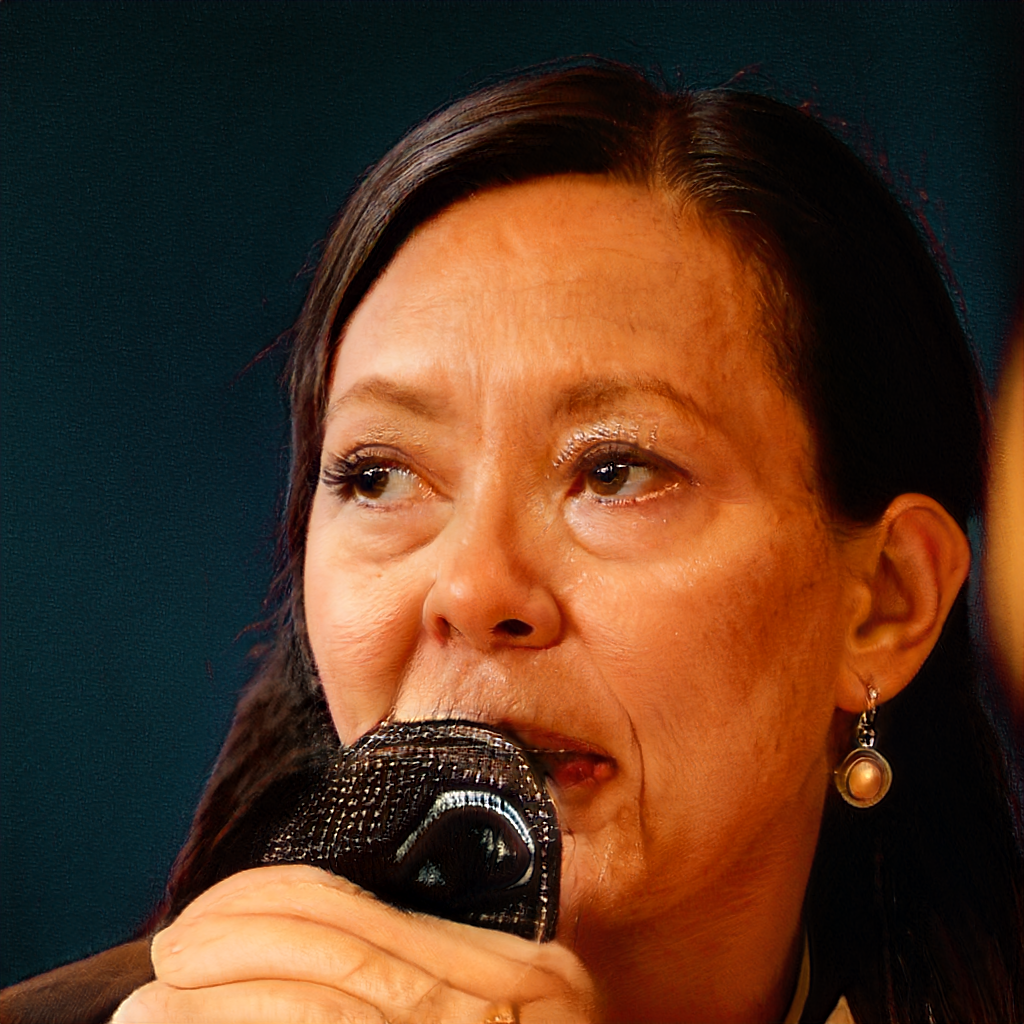

In [49]:
inverse_transform(image.squeeze(0))